In [1]:
import torch
import torch.nn as nn

In [2]:
torch.cuda.is_available()

True

In [5]:
# SVD
import numpy as np

# Example weight matrix W (this would typically come from a trained model layer)
W = np.random.rand(100, 50)  # Example of a weight matrix (100x50)

# Perform Singular Value Decomposition
U, S, Vt = np.linalg.svd(W, full_matrices=False)
print(U.shape, S.shape, Vt.shape)  
# Select the number of singular values to keep (k')
k = 10  # For example, keep only the top 10 singular values

# Truncate S, U, Vt to keep only the top k singular values
U_k = U[:, :k]
S_k = np.diag(S[:k])
(S_k)
Vt_k = Vt[:k, :]
print(U_k.shape, S_k.shape, Vt_k.shape)
# Reconstruct the compressed weight matrix
W_compressed = np.dot(U_k, np.dot(S_k, Vt_k))

# W_compressed is now a low-rank approximation of W, with fewer parameters
print(W_compressed.shape)


(100, 50) (50,) (50, 50)
(100, 10) (10, 10) (10, 50)
(100, 50)


## read image

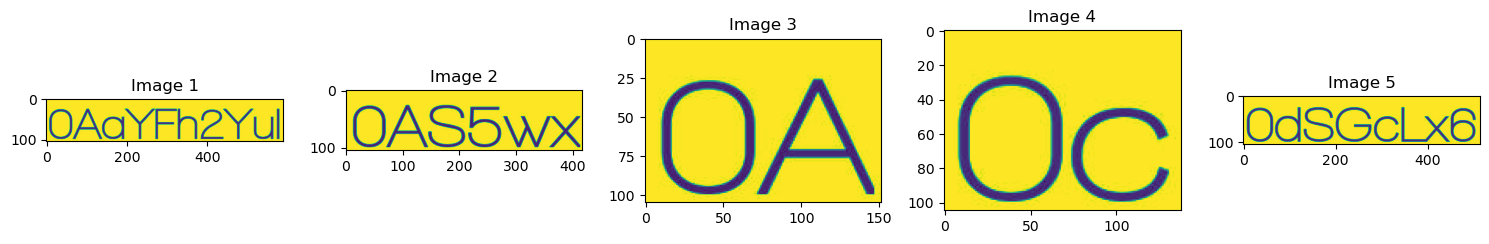

In [5]:
# read and show image from font_patch folder
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

# read all images from font_patch folder. The structure is font_patch/<class_name>/<image_name>.jpg>
def read_images_from_folder(folder, classname=None):
    images = []
    if not classname:
        for classname in os.listdir(folder):
            for filename in os.listdir(os.path.join(folder, classname)):
                img_path = os.path.join(folder, classname, filename)
                img = Image.open(img_path).convert('L')
                images.append(np.array(img))
    else:
        for filename in os.listdir(os.path.join(folder, classname)):
            img_path = os.path.join(folder, classname, filename)
            img = Image.open(img_path).convert('L')
            images.append(np.array(img))
    return images

images = read_images_from_folder('font_patch', "Walkway")

# show image
def show_image(image, title=None):
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# show 5 images in a grid WITH AXIS
def show_images_in_grid(images, titles=None, cols=5):
    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            if titles:
                ax.set_title(titles[i])
        ax.axis('on')
    plt.tight_layout()
    plt.show()

show_images_in_grid(images, titles=[f'Image {i+1}' for i in range(len(images))], cols=5)


## extract the patch of each image

In [6]:
# each image has the shape (105, X, 3). We need to extract different patches with the size (105,105,3) from the image
def extract_patches(image, num_patch=3, patch_size=(105, 105)):
    patches = []
    h, w = image.shape
    for _ in range(num_patch):
        x = np.random.randint(0, w - patch_size[1] + 1)
        y = np.random.randint(0, h - patch_size[0] + 1)
        patch = image[y:y + patch_size[0], x:x + patch_size[1]]
        patches.append(patch)
    return patches

# extract patches from the all images
patches = []
for image in images:
    patches.extend(extract_patches(image))

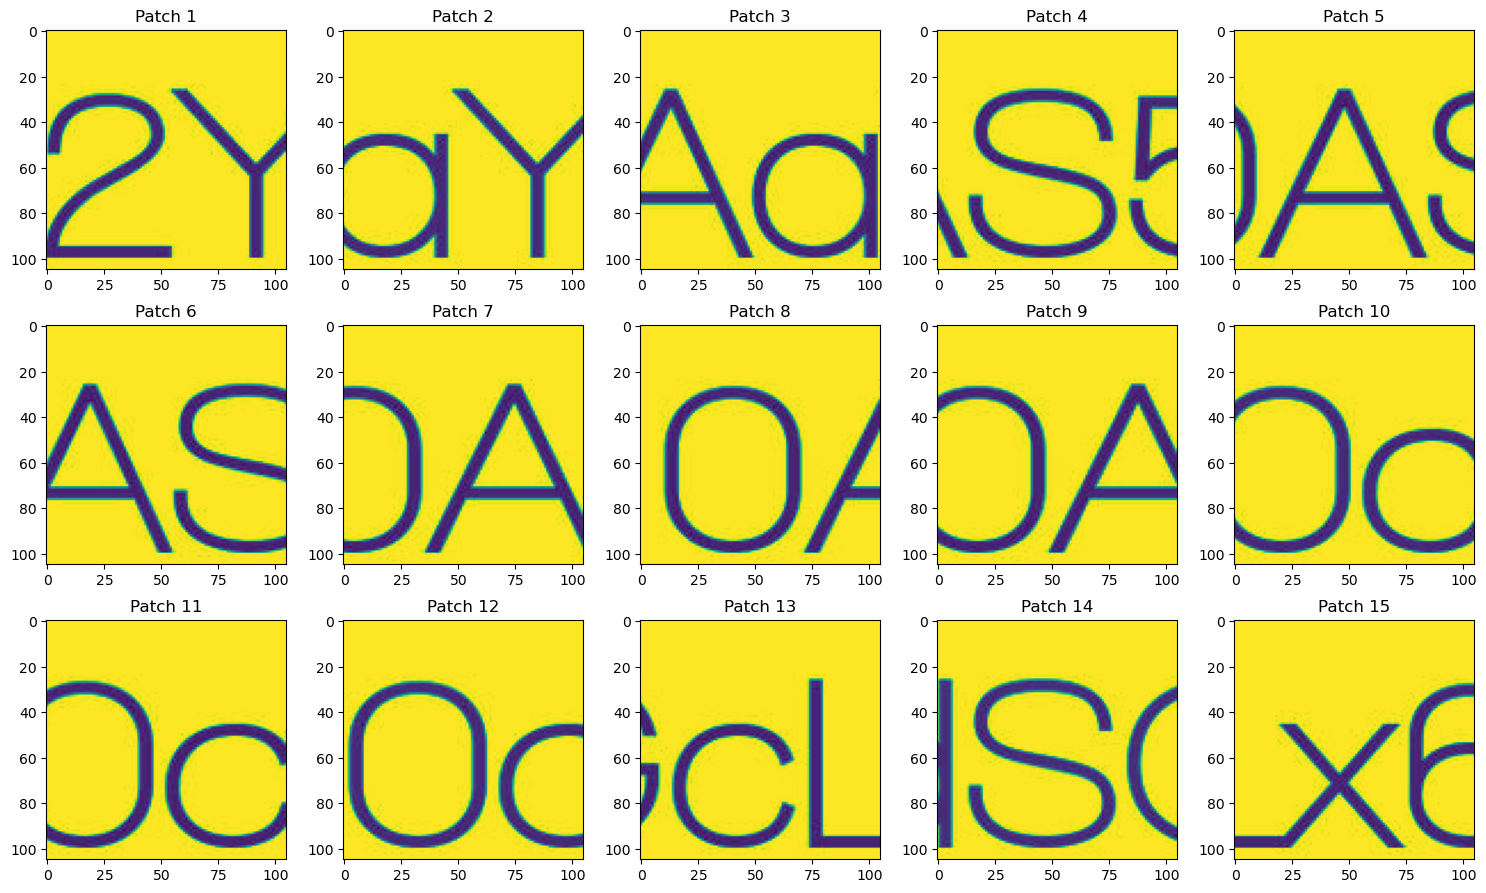

In [7]:
show_images_in_grid(patches, titles=[f'Patch {i+1}' for i in range(len(patches))], cols=5)


## Dataset (use this code in Kaggle)

In [8]:
import torchvision

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
from io import BytesIO
import os
import random
import math # Needed for ceiling division

# Helper function to extract patches (updated for grayscale)
def extract_patches(image_array, num_patch=3, patch_size=(105, 105)):
    """
    Extracts a specified number of random patches from a single image array.
    Handles both grayscale (2D) and color (3D) images.

    Args:
        image_array (np.ndarray): The input image (Height, Width) or (Height, Width, Channels).
        num_patch (int): The number of patches to extract.
        patch_size (tuple): The (height, width) of the patches.

    Returns:
        list[np.ndarray]: A list containing the extracted patch arrays.
                          Patches will be 2D (H, W) if input is grayscale.
                          Returns an empty list if image is smaller than patch size.
    """
    patches = []
    if image_array.ndim == 2: # Grayscale
        h, w = image_array.shape
        is_grayscale = True
    elif image_array.ndim == 3: # Color
        h, w, _ = image_array.shape
        is_grayscale = False
    else:
        print(f"Warning: Unexpected image array dimension: {image_array.ndim}. Skipping patch extraction.")
        return []

    patch_h, patch_w = patch_size

    # Check if image is large enough for at least one patch
    if h < patch_h or w < patch_w:
        # print(f"Warning: Image shape ({h}, {w}) is smaller than patch size ({patch_h}, {patch_w}). Skipping patch extraction for this image.")
        return [] # Return empty list if image is too small

    for _ in range(num_patch):
        # Ensure random coordinates are within valid bounds
        x = np.random.randint(0, w - patch_w + 1)
        y = np.random.randint(0, h - patch_h + 1)
        if is_grayscale:
            patch = image_array[y:y + patch_h, x:x + patch_w] # Shape: (patch_h, patch_w)
        else:
             patch = image_array[y:y + patch_h, x:x + patch_w, :] # Shape: (patch_h, patch_w, C) - Kept for generality but not used in this specific request
        patches.append(patch)
    return patches

# Custom Dataset for lazy-loading from BCF
class BCFImagePatchDataset(Dataset):
    """
    PyTorch Dataset for loading images from a custom BCF file format lazily
    and extracting patches on the fly. Loads images as grayscale.
    """
    def __init__(self, bcf_file, label_file, num_patch=3, patch_size=(105, 105)):
        """
        Initializes the dataset by reading metadata but not image data.

        Args:
            bcf_file (str): Path to the BCF file.
            label_file (str): Path to the label file.
            num_patch (int): Number of patches to extract per image.
            patch_size (tuple): (height, width) of patches.
        """
        self.bcf_file = bcf_file
        self.label_file = label_file
        self.num_patch = num_patch
        self.patch_size = patch_size # Store patch_size for use in collate_fn reference

        self.labels = None
        self.num_images = 0
        self.image_sizes = None
        self.image_offsets = None
        self.data_start_offset = 0 # Byte offset in BCF where actual image data begins

        self._read_metadata()

    def _read_metadata(self):
        """Reads labels and image size/offset information from the files."""
        try:
            # Read label file
            with open(self.label_file, 'rb') as f:
                self.labels = np.frombuffer(f.read(), dtype=np.uint32)
                print(f"Read {len(self.labels)} labels.")

            # Read BCF header
            with open(self.bcf_file, 'rb') as f:
                self.num_images = np.frombuffer(f.read(8), dtype=np.int64)[0]
                print(f"BCF header indicates {self.num_images} images.")

                # Check for consistency
                if len(self.labels) != self.num_images:
                    raise ValueError(f"Mismatch between number of labels ({len(self.labels)}) and images in BCF header ({self.num_images}).")

                # Read all image sizes
                sizes_bytes = f.read(self.num_images * 8)
                self.image_sizes = np.frombuffer(sizes_bytes, dtype=np.int64)
                print(f"Read {len(self.image_sizes)} image sizes.")

                # Calculate the starting offset of the actual image data blob
                self.data_start_offset = 8 + self.num_images * 8 # 8 bytes for num_images + 8 bytes per size

                # Calculate cumulative offsets for seeking
                # Offset[i] is the starting byte of image i relative to data_start_offset
                self.image_offsets = np.zeros(self.num_images + 1, dtype=np.int64)
                np.cumsum(self.image_sizes, out=self.image_offsets[1:])
                print("Calculated image offsets.")

        except FileNotFoundError as e:
            print(f"Error: File not found - {e}")
            raise
        except Exception as e:
            print(f"Error reading metadata: {e}")
            raise

    def __len__(self):
        """Returns the total number of images in the dataset."""
        return self.num_images

    def __getitem__(self, idx):
        """
        Loads one image as grayscale, extracts patches, and returns patches with the label.

        Args:
            idx (int): The index of the image to retrieve.

        Returns:
            tuple: (list[np.ndarray], int): A tuple containing:
                     - A list of NumPy arrays, each representing a patch (H, W).
                     - The integer label for the image.
               Returns ([], -1) if image reading or patch extraction fails.
        """
        if idx >= self.num_images or idx < 0:
            raise IndexError(f"Index {idx} out of bounds for {self.num_images} images.")

        label = self.labels[idx]
        offset = self.image_offsets[idx]
        size = self.image_sizes[idx]

        try:
            # Open the BCF file, seek, read only the required bytes
            with open(self.bcf_file, 'rb') as f:
                f.seek(self.data_start_offset + offset)
                image_bytes = f.read(size)

            # Convert bytes to image (grayscale) and then to numpy array
            # Use 'L' for grayscale conversion
            img = Image.open(BytesIO(image_bytes)).convert('L')
            img_array = np.array(img) # Shape: (H, W)

            # Extract patches from this single grayscale image
            patches = extract_patches(img_array, self.num_patch, self.patch_size)

            return patches, label # Return list of patches and the single label

        except FileNotFoundError:
            print(f"Error: BCF file not found during __getitem__ for index {idx}.")
            return [], -1 # Indicate error
        except Exception as e:
            print(f"Error processing image index {idx}: {e}")
            return [], -1 # Indicate error


# Custom collate function for the DataLoader (updated for grayscale)
def patch_collate_fn(batch, patch_size_tuple):
    """
    Collates data from the BCFImagePatchDataset (handling grayscale).

    Takes a batch of [(patches_list_img1, label1), (patches_list_img2, label2), ...],
    flattens the patches, converts them to a tensor, adds a channel dimension,
    normalizes, and returns a single batch tensor for patches and labels.

    Args:
        batch (list): A list of tuples, where each tuple is the output
                      of BCFImagePatchDataset.__getitem__.
        patch_size_tuple (tuple): The (height, width) of patches, needed for empty tensor shape.


    Returns:
        tuple: (torch.Tensor, torch.Tensor): A tuple containing:
                 - Patches tensor (BatchSize * NumPatches, 1, Height, Width)
                 - Labels tensor (BatchSize * NumPatches)
    """
    all_patches = []
    all_labels = []
    valid_batch_items = 0

    for item in batch:
        patches, label = item
        # Ensure item is valid (e.g., image wasn't too small, no read errors)
        if patches and label != -1:
             # Only add patches if the list is not empty
            all_patches.extend(patches)
            # Repeat the label for each patch extracted from the image
            all_labels.extend([label] * len(patches))
            valid_batch_items += 1
        # else:
            # Optionally print a warning if an item was skipped
            # print(f"Skipping item in collate_fn due to previous error or no patches.")

    # If no valid patches were collected in the batch (e.g., all images too small)
    if not all_patches:
        # Return empty tensors of appropriate type but 0 size in the batch dimension
        # Shape for grayscale: (0, 1, H, W)
        patch_h, patch_w = patch_size_tuple
        return torch.empty((0, 1, patch_h, patch_w), dtype=torch.float), torch.empty((0,), dtype=torch.long)

    # Convert list of NumPy arrays (each H, W) to a single NumPy array
    patches_np = np.array(all_patches) # Shape: (TotalPatches, H, W)

    # Convert to PyTorch tensor, normalize
    patches_tensor = torch.tensor(patches_np).float() / 255.0 # Shape: (TotalPatches, H, W)

    # Add channel dimension: (TotalPatches, H, W) -> (TotalPatches, 1, H, W)
    patches_tensor = patches_tensor.unsqueeze(1)

    # Convert labels to PyTorch tensor
    labels_tensor = torch.tensor(all_labels, dtype=torch.long) # Use long for classification labels

    # print(f"Collate - Input Batch Size: {len(batch)}, Valid Items: {valid_batch_items}, Output Patches Shape: {patches_tensor.shape}, Output Labels Shape: {labels_tensor.shape}")

    return patches_tensor, labels_tensor


# --- Main Execution ---

# Example usage:
bcf_train = '/kaggle/input/adobe-visual-font-recognition/train.bcf'
bcf_val = '/kaggle/input/adobe-visual-font-recognition/val.bcf'
bcf_test = '/kaggle/input/adobe-visual-font-recognition/test.bcf'

label_train = '/kaggle/input/adobe-visual-font-recognition/train.label'
label_val = '/kaggle/input/adobe-visual-font-recognition/val.label'
label_test = '/kaggle/input/adobe-visual-font-recognition/test.label'

BATCH_SIZE = 1024 # Adjust as needed for your GPU memory
NUM_PATCHES_PER_IMAGE = 1
PATCH_SIZE = (105, 105) # Define patch size tuple
NUM_WORKERS = 4 # Adjust based on your CPU cores, helps speed up loading

# 1. Create the full dataset instance
try:
    train_dataset = BCFImagePatchDataset(
        bcf_file=bcf_train,
        label_file=label_train,
        num_patch=NUM_PATCHES_PER_IMAGE,
        patch_size=PATCH_SIZE # Pass patch_size to dataset
    )

    val_dataset = BCFImagePatchDataset(
        bcf_file=bcf_val,
        label_file=label_val,
        num_patch=NUM_PATCHES_PER_IMAGE,
        patch_size=PATCH_SIZE # Pass patch_size to dataset
    )

    test_dataset = BCFImagePatchDataset(
        bcf_file=bcf_test,
        label_file=label_test,
        num_patch=NUM_PATCHES_PER_IMAGE,
        patch_size=PATCH_SIZE # Pass patch_size to dataset
    )

    # 2. Create indices for splitting
    # Ensure labels were loaded before stratifying
    if train_dataset.labels is None:
         raise ValueError("Labels could not be loaded. Cannot stratify split.")

    # 4. Create DataLoaders using the custom collate function
    # We need to pass the PATCH_SIZE to the collate function. functools.partial is good for this.
    from functools import partial
    collate_wrapper = partial(patch_collate_fn, patch_size_tuple=PATCH_SIZE)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        collate_fn=collate_wrapper, # Use the wrapper
        pin_memory=True # Set to True if using GPU for faster data transfer
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        collate_fn=collate_wrapper, # Use the wrapper
        pin_memory=True # Set to True if using GPU for faster data transfer
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_wrapper, # Use the wrapper
        pin_memory=True
    )

    # 5. Example loop through the train loader
    print("\nTesting DataLoader...")
    num_batches_to_test = 5
    for i, (batch_patches, batch_labels) in enumerate(train_loader):
        if batch_patches.numel() == 0: # Check if the batch is empty
             print(f"Batch {i+1}: Skipped (likely due to all images being too small or read errors)")
             continue

        print(f"Batch {i+1}: Patches shape: {batch_patches.shape}, Labels shape: {batch_labels.shape}")
        # Example: Check channel dimension is 1
        if batch_patches.shape[1] != 1:
             print(f"Error: Unexpected channel dimension: {batch_patches.shape[1]}")
        # print(f"Batch {i+1}: Labels: {batch_labels}") # Optional: print labels

        # --- Your training code would go here ---
        # model(batch_patches) # Ensure your model expects input shape (B, 1, H, W)
        # loss = criterion(outputs, batch_labels)
        # ...
        # ----------------------------------------

        if i >= num_batches_to_test - 1:
            break

    print("\nDataLoader setup complete and test loop finished.")

except Exception as e:
    print(f"\nAn error occurred during dataset/dataloader setup: {e}")
    import traceback
    traceback.print_exc() # Print detailed traceback
    # Depending on the error, you might want to investigate file paths,
    # file formats, or permissions.




KeyboardInterrupt: 

## Transformations


In [9]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import numpy as np
import random
from PIL import Image, ImageDraw

# 1. Add Gaussian Noise
class AddGaussianNoise:
    """Add Gaussian noise with zero mean and specified standard deviation."""
    def __init__(self, mean=0., std=3.0):
        self.mean = mean
        self.std = std
        
    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            noise = torch.randn_like(img) * (self.std) + self.mean
            noisy_img = img + noise
            return torch.clamp(noisy_img, 0, 1)
        else:
            tensor = F.to_tensor(img)
            noise = torch.randn_like(tensor) * (self.std) + self.mean
            noisy_tensor = torch.clamp(tensor + noise, 0, 1)
            return F.to_pil_image(noisy_tensor)

# 4. Add Shading (illumination gradient)
class AddShading:
    """Add illumination gradient to simulate shading effects."""
    def __init__(self, direction='random'):
        self.direction = direction  # 'horizontal', 'vertical', 'diagonal', 'random'
        
    def __call__(self, img):
        # Convert tensor to PIL if needed
        if isinstance(img, torch.Tensor):
            is_tensor = True
            if img.dim() == 3 and img.shape[0] == 1:  # (1, H, W)
                pil_img = F.to_pil_image(img)
            elif img.dim() == 2:  # (H, W)
                pil_img = F.to_pil_image(img.unsqueeze(0))
            else:
                pil_img = F.to_pil_image(img)
        else:
            is_tensor = False
            pil_img = img
            
        # Get image dimensions
        w, h = pil_img.size
        
        # Choose direction
        if self.direction == 'random':
            direction = random.choice(['horizontal', 'vertical', 'diagonal'])
        else:
            direction = self.direction
            
        # Create gradient mask as a new image
        mask = Image.new('L', (w, h), 255)
        draw = ImageDraw.Draw(mask)
        
        if direction == 'horizontal':
            for x in range(w):
                alpha = int(255 * (0.7 + 0.3 * x / w))
                draw.line([(x, 0), (x, h)], fill=alpha)
        elif direction == 'vertical':
            for y in range(h):
                alpha = int(255 * (0.7 + 0.3 * y / h))
                draw.line([(0, y), (w, y)], fill=alpha)
        else:  # diagonal
            for y in range(h):
                for x in range(w):
                    alpha = int(255 * (0.7 + 0.3 * (x/w + y/h) / 2))
                    draw.point((x, y), fill=alpha)
                    
        # Apply gradient mask to the image
        shaded_img = Image.composite(pil_img, Image.new(pil_img.mode, pil_img.size, 0), mask)
        
        # Return in original format
        if is_tensor:
            tensor = F.to_tensor(shaded_img)
            if img.dim() == 2:
                return tensor.squeeze(0)
            return tensor
        return shaded_img

# 5. Variable Character Spacing
class VariableCharacterSpacing:
    """
    Simulates variable character spacing by slicing the image and adjusting spacing.
    This is an approximation of the spacing that would normally be applied during rendering.
    """
    def __init__(self, mean_spacing=10, std_spacing=40, min_spacing=0, max_spacing=50):
        self.mean_spacing = mean_spacing
        self.std_spacing = std_spacing
        self.min_spacing = min_spacing
        self.max_spacing = max_spacing
        
    def __call__(self, img):
        # Convert tensor to PIL if needed
        if isinstance(img, torch.Tensor):
            is_tensor = True
            if img.dim() == 3 and img.shape[0] == 1:  # (1, H, W)
                pil_img = F.to_pil_image(img)
            elif img.dim() == 2:  # (H, W)
                pil_img = F.to_pil_image(img.unsqueeze(0))
            else:
                pil_img = F.to_pil_image(img)
        else:
            is_tensor = False
            pil_img = img
        
        # Get image dimensions
        w, h = pil_img.size
        
        # For text, we'll divide the image into vertical segments
        # This is a simplified approach - real character spacing would require text detection
        num_segments = max(2, w // 20)  # Approximate number of characters by width
        
        # Calculate segment width
        segment_width = w // num_segments
        
        # Create a new image with potential extra width for spacing
        max_new_width = w + (num_segments - 1) * self.max_spacing
        new_img = Image.new(pil_img.mode, (max_new_width, h), color=255)  # White background
        
        # Current x position for placing segments
        current_x = 0
        
        # Slice the image into segments and place with variable spacing
        for i in range(num_segments):
            # Extract segment
            left = i * segment_width
            right = min((i + 1) * segment_width, w)
            segment = pil_img.crop((left, 0, right, h))
            
            # Paste segment at current position
            new_img.paste(segment, (current_x, 0))
            
            # Update current_x with random spacing for next segment
            if i < num_segments - 1:  # Don't add spacing after the last segment
                # Generate spacing from gaussian distribution and bound it
                spacing = int(np.random.normal(self.mean_spacing, self.std_spacing))
                spacing = max(self.min_spacing, min(spacing, self.max_spacing))
                current_x += (right - left) + spacing
            else:
                current_x += (right - left)
        
        # Crop the image to the actual used width
        new_img = new_img.crop((0, 0, current_x, h))
        
        # Return in original format
        if is_tensor:
            tensor = F.to_tensor(new_img)
            if img.dim() == 2:
                return tensor.squeeze(0)
            return tensor
        return new_img

# 6. Variable Aspect Ratio
class VariableAspectRatio:
    """Randomly squeeze or stretch the image width by a ratio between 5/6 and 7/6"""
    def __init__(self, min_ratio=5/6, max_ratio=7/6):
        self.min_ratio = min_ratio
        self.max_ratio = max_ratio
        
    def __call__(self, img):
        ratio = random.uniform(self.min_ratio, self.max_ratio)
        
        if isinstance(img, torch.Tensor):
            if img.dim() == 3:  # (C, H, W)
                c, h, w = img.shape
                new_w = int(w * ratio)
                return F.resize(img, [h, new_w])
            elif img.dim() == 2:  # (H, W)
                h, w = img.shape
                new_w = int(w * ratio)
                return F.resize(img.unsqueeze(0), [h, new_w]).squeeze(0)
        else:
            w, h = img.size
            new_w = int(w * ratio)
            return img.resize((new_w, h), Image.BILINEAR)

# Complete transformation pipeline with all techniques
def get_font_augmentation_transforms():
    """Returns a composed transform with all font-specific augmentations."""
    transform_list = [
        # 1. Noise (50% probability)
        transforms.RandomApply([AddGaussianNoise(mean=0, std=3.0)], p=0.5),
        
        # 2. Blur (50% probability)
        transforms.RandomApply([
            transforms.GaussianBlur(kernel_size=5, sigma=(2.5, 3.5))
        ], p=0.5),
        
        # 3. Perspective Rotation (50% probability)
        transforms.RandomApply([
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), 
                                   scale=(0.9, 1.1), shear=10)
        ], p=0.5),
        
        # 4. Shading (50% probability)
        transforms.RandomApply([AddShading(direction='random')], p=0.5),

        # 5. Variable Character Spacing (50% probability)
        transforms.RandomApply([
            VariableCharacterSpacing(
                mean_spacing=10, 
                std_spacing=40, 
                min_spacing=0, 
                max_spacing=50
            )
        ], p=0.5),

        # # 6. Variable Aspect Ratio (50% probability)
        transforms.RandomApply([
            VariableAspectRatio(min_ratio=5/6, max_ratio=7/6)
        ], p=0.5),
        
        # Convert to tensor for model input
        transforms.ToTensor(),
    ]
    
    return transforms.Compose(transform_list)

# For use with the BCFImagePatchDataset
def apply_augmentations_to_dataset(dataset, use_augmentation=True):
    """Updates the dataset's __getitem__ method to apply augmentations."""
    if use_augmentation:
        original_getitem = dataset.__getitem__
        transforms = get_font_augmentation_transforms()
        
        def new_getitem(self, idx):
            patches, label = original_getitem(self, idx)
            if patches:
                augmented_patches = []
                for patch in patches:
                    # Convert to PIL for transforms
                    pil_patch = Image.fromarray(patch)
                    # Apply transforms and convert back to tensor
                    augmented_patch = transforms(pil_patch)
                    augmented_patches.append(augmented_patch)
                return augmented_patches, label
            return patches, label
        
        dataset.__getitem__ = new_getitem.__get__(dataset)
    
    return dataset

In [14]:
patches[0].shape

(105, 105)

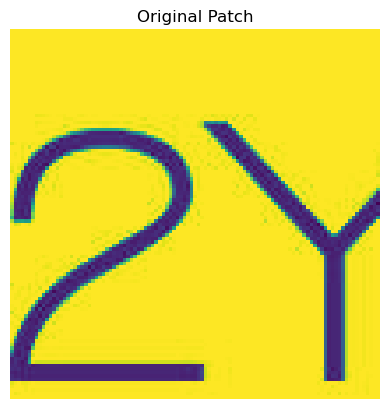

In [10]:
# show me the image of patches[0]
show_image(patches[0], "Original Patch")

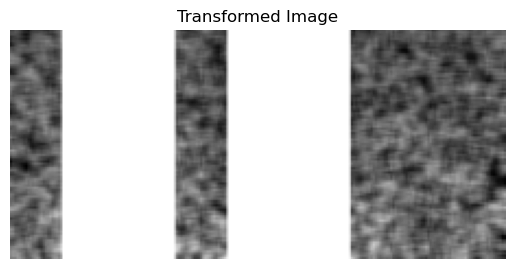

In [23]:
transformed_image = get_font_augmentation_transforms()(Image.fromarray(patches[0]))
# Add this function to handle tensor image display
def show_tensor_image(tensor, title=None):
    """
    Display a PyTorch tensor image correctly by converting to the right format.
    Works with tensors in (C, H, W) format.
    """
    # Convert tensor to numpy array
    if isinstance(tensor, torch.Tensor):
        # If tensor is (C, H, W) format, convert to (H, W) or (H, W, C)
        if tensor.dim() == 3 and tensor.shape[0] in (1, 3):
            # For grayscale, just remove the channel dimension
            if tensor.shape[0] == 1:
                img_np = tensor.squeeze(0).numpy()
            else:
                # For RGB, move channels to the end
                img_np = tensor.permute(1, 2, 0).numpy()
        else:
            img_np = tensor.numpy()
    else:
        img_np = np.array(tensor)
    
    # Display with appropriate colormap
    plt.imshow(img_np, cmap='gray' if len(img_np.shape) == 2 else None)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

show_tensor_image(transformed_image, title="Transformed Image")

## SCAE
- convtranspose
+) H_out = (H_in - 1) * stride[0] - 2 * padding[0] + dilation[0] * (kernel_size[0] - 1) + output_padding[0] + 1
+) W_out = (W_in - 1) * stride[1] - 2 * padding[1] + dilation[1] * (kernel_size[1] - 1) + output_padding[1] + 1

- unpool
H_out = (H_in - 1) * stride[0] - 2 * padding[0] + kernel_size[0]

In [50]:
# model
"""
First we train the SCAE model on the patches.
It contains two conv and 2 deconv layers.
- conv1: 60x60, 64 filters, stride 1, padding 1 (on all four directions up down left right)
- pool1: stride 2, kernel size 2, padding 0 (on all four directions up down left right)
- conv2: 3x3, 128 filters, stride 1, padding 1 (on all four directions up down left right)
- deconv1: (from 24x24x128 to 24x24x64), 64 filters, stride 1, padding 1, kernel size 3 (on all four directions up down left right)
- unpool1: (from 24x24x64 to 48x48x64), 64 filters, stride 2, kernel size 2, padding 0 (on all four directions up down left right)
- deconv2: (from 48x48x64 to 105x105x3), 3 filters, kernel size 60, stride 1, padding 1, dilation 0, output_padding 0 
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class SCAE(nn.Module):
    def __init__(self, normalization_type="batch_norm", use_dropout=False, dropout_prob=0.3, activation="leaky_relu"):
        super(SCAE, self).__init__()

        def norm_layer(num_features):
            if normalization_type == "batch_norm":
                return nn.BatchNorm2d(num_features)
            elif normalization_type == "group_norm":
                return nn.GroupNorm(num_groups=8, num_channels=num_features)
            elif normalization_type == "layer_norm":
                return nn.LayerNorm([num_features, 26, 26])  # nếu input là 26x26
            else:
                return nn.Identity()

        def activation_layer():
            return nn.LeakyReLU(inplace=True) if activation == "leaky_relu" else nn.ReLU(inplace=True)

        def dropout_layer():
            return nn.Dropout2d(dropout_prob) if use_dropout else nn.Identity()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=60, stride=1, padding=1),
            norm_layer(64),
            activation_layer(),
            dropout_layer(),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            norm_layer(128),
            activation_layer(),
            dropout_layer(),

            nn.MaxPool2d(2, 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            norm_layer(64),
            activation_layer(),
            dropout_layer(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(64, 1, kernel_size=60, stride=1, padding=1),
            activation_layer(),
            
        )

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
            print(x.shape)
        for layer in self.decoder:
            x = layer(x)
            print(x.shape)
        return x

# test with the first patch
scae = SCAE().to(device)
scae.eval()

for batch in train_loader:
    print(batch.shape)
    print(scae(batch.to(device)).shape)
    # show_images_in_grid(batch.permute(0, 2, 3, 1).numpy(), titles=[f'Patch {i+1}' for i in range(len(batch))], cols=4)
    break

torch.Size([4, 1, 105, 105])
torch.Size([4, 64, 48, 48])
torch.Size([4, 64, 48, 48])
torch.Size([4, 64, 48, 48])
torch.Size([4, 64, 48, 48])
torch.Size([4, 64, 24, 24])
torch.Size([4, 128, 24, 24])
torch.Size([4, 128, 24, 24])
torch.Size([4, 128, 24, 24])
torch.Size([4, 128, 24, 24])
torch.Size([4, 128, 12, 12])
torch.Size([4, 128, 24, 24])
torch.Size([4, 64, 24, 24])
torch.Size([4, 64, 24, 24])
torch.Size([4, 64, 24, 24])
torch.Size([4, 64, 24, 24])
torch.Size([4, 64, 48, 48])
torch.Size([4, 1, 105, 105])
torch.Size([4, 1, 105, 105])
torch.Size([4, 1, 105, 105])


In [54]:
# now we train the model on the patches
# convert patches to tensor and normalize
# patches = torch.tensor(patches).squeeze(-1)
patches_tensor = (patches).permute(0, 3, 1, 2).float() / 255.0
print(patches.shape) # (num_patches, 3, 105, 105)
# create dataloader
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from tqdm import tqdm

# create dataloader
train_patches, test_patches = train_test_split(patches_tensor, test_size=0.2, random_state=42)
train_loader = DataLoader(train_patches, batch_size=4, shuffle=True)
test_loader = DataLoader(test_patches, batch_size=4, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(scae.parameters(), lr=0.01)

num_epochs = 1
for epoch in range(num_epochs):
    # break
    scae.train()
    running_loss = 0.0
    # Unpack the tuple yielded by the DataLoader
    for patches in tqdm(train_loader): # Unpack here
        # Skip empty batches if any occurred
        if patches.numel() == 0:
            continue

        patches = patches.to(device)
        # Note: labels are loaded but not used for the autoencoder training
        # labels = labels.to(device) # Optional: move labels to device if needed later

        optimizer.zero_grad()
        outputs = scae(patches) # Use patches as input
        loss = criterion(outputs, patches) # Use patches as target for reconstruction
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Avoid division by zero if train_loader is empty or only contained empty batches
    if len(train_loader) > 0:
         avg_loss = running_loss / len(train_loader) # Or better: divide by number of non-empty batches processed
         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    else:
         print(f"Epoch [{epoch+1}/{num_epochs}], No batches processed.")

torch.Size([2, 105, 105, 1])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 64, 48, 48])
torch.Size([1, 64, 48, 48])
torch.Size([1, 64, 48, 48])
torch.Size([1, 64, 48, 48])
torch.Size([1, 64, 24, 24])
torch.Size([1, 128, 24, 24])
torch.Size([1, 128, 24, 24])
torch.Size([1, 128, 24, 24])
torch.Size([1, 128, 24, 24])
torch.Size([1, 128, 12, 12])
torch.Size([1, 128, 24, 24])
torch.Size([1, 64, 24, 24])
torch.Size([1, 64, 24, 24])
torch.Size([1, 64, 24, 24])
torch.Size([1, 64, 24, 24])
torch.Size([1, 64, 48, 48])
torch.Size([1, 1, 105, 105])
torch.Size([1, 1, 105, 105])


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

Epoch [1/1], Loss: 0.0062


In [ ]:
# now we need to store the encoder of scae as the pretrained model



## Full architecture

In [52]:
torch.cuda.empty_cache()
del model

In [53]:
import gc
gc.collect()

10289

In [ ]:
class convolution_unsupervised(nn.Module):
    def __init__(self, pretrained_scae, num_classes=2383):
        super().__init__()
        self.pretrained_scae = pretrained_scae  # đã có encoder rồi

        # Không tạo lại encoder ở đây nữa
        # Thêm một head CNN sau encoder của SCAE
        #
        self.cnn_head = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256), # xem co the them dropout, relu o tr hay o sau batchnorm, xem la activation de Relu, Sigmoid, LeakyRelu
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256), # test vs 4, 5 block conv
        )

        # Tính shape đầu vào của Linear theo cách động
        self.flatten = nn.Flatten()

        self.fully_connected = nn.Sequential(
            nn.Linear(256 * 12 * 12, 4096), # luu y them doan nay
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        print("Input:", x.shape)
        x = self.pretrained_scae.encoder(x)  # dùng đúng encoder từ SCAE
        print("SCAE Encoder Output:", x.shape)
        x = self.cnn_head(x)
        print("CNN Head Output:", x.shape)
        x = self.flatten(x)
        print("Flattened:", x.shape)
        x = self.fully_connected(x)
        print("Final Output:", x.shape)
        return x

model = convolution_unsupervised(scae, num_classes=2383).to(device)

for batch in train_loader:
    print(batch.shape)
    print(model(batch.to(device)).shape)
    # show_images_in_grid(batch.permute(0, 2, 3, 1).numpy(), titles=[f'Patch {i+1}' for i in range(len(batch))], cols=4)
    break

torch.Size([1, 1, 105, 105])
Input: torch.Size([1, 1, 105, 105])
SCAE Encoder Output: torch.Size([1, 128, 12, 12])
CNN Head Output: torch.Size([1, 256, 12, 12])
Flattened: torch.Size([1, 36864])
Final Output: torch.Size([1, 2383])
torch.Size([1, 2383])


In [ ]:
# tối ưu cái qtrinh train bằng deepspeed

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = convolution_unsupervised(scae).to(device)

criterion = nn.MSELoss()
# optimizer with momentum = 0.9, weight decay = 0.0005
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # Unpack the tuple yielded by the DataLoader
    for patches in tqdm(train_loader): # Unpack here
        # Skip empty batches if any occurred
        if patches.numel() == 0:
            continue

        patches = patches.to(device)
        # Note: labels are loaded but not used for the autoencoder training
        # labels = labels.to(device) # Optional: move labels to device if needed later
        labels = torch.zeros(patches.shape[0], dtype=torch.float32).to(device) # Dummy labels for training
        optimizer.zero_grad()
        outputs = model(patches) # Use patches as input
        loss = criterion(outputs, labels) # Use patches as target for reconstruction
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Avoid division by zero if train_loader is empty or only contained empty batches
    if len(train_loader) > 0:
         avg_loss = running_loss / len(train_loader) # Or better: divide by number of non-empty batches processed
         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    else:
         print(f"Epoch [{epoch+1}/{num_epochs}], No batches processed.")

  0%|          | 0/1 [00:00<?, ?it/s]

Input: torch.Size([1, 1, 105, 105])
SCAE Encoder Output: torch.Size([1, 128, 12, 12])
CNN Head Output: torch.Size([1, 256, 12, 12])
Flattened: torch.Size([1, 36864])
Final Output: torch.Size([1, 2383])


c:\Users\ADMIN\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2383])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

Epoch [1/1], Loss: 0.0000
